> ERC Starting Grant on COeXISTENCE between humans and machines in urban mobility.


<img src="../images/img_mileston1.png" alt="Milestone 1 Image" width="500" height="400">

# Title: Machine training using PPO algorithm
## Name: Anastasia
### Date: June 27, 2024
---

### Description

> In this notebook, we implement the training of three independent machine agents using the PPO algorithm.
---

## Objective

> The purpose of this notebook is to understand whether PPO algorithm can train effectively our RL agents.
---

## Experiment Summary

### Network Architecture
- Csomor network


### Agents
| **Type**          |           |
|-------------------|---------------------|
| **Number**        | 3 machines |
| **Total demand** | random |


### Origin and Destination Details
| **Origin Count**      | 2                            |
|-----------------------|------------------------------|
| **Destination Count** | 2                            |
| **Origin Pairing**    | 279952229#0, 115604053       |
| **Destination Pairing**| -115602933#2, -441496282#1     |

    

### Hardware Utilized for Experiment Execution
| **Type of Machine** | Personal computer (or server) |
|----------------------|-------------------------------|
| **CPU**              | 12th Gen Intel(R) Core(TM) i7-1255U |
|                      | Cores: 10                   |
|                      | Sockets: 1                  |
|                      | Base Speed: 1.70 GHz        |
| **Memory**           | 16GB                          |
| **Disc (SSD)**       | 477 GB                        |
| **Operating System** | Windows 11                    |


### Imported libraries 

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensordict.nn import TensorDictModule, TensorDictSequential
import torch
from torchrl.collectors import SyncDataCollector
from torch.distributions import Categorical
from torchrl.envs.libs.pettingzoo import PettingZooWrapper
from torchrl.envs.transforms import TransformedEnv, RewardSum
from torchrl.envs.utils import check_env_specs
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.modules import MultiAgentMLP, ProbabilisticActor
from torchrl.objectives.value import GAE
from torchrl.objectives import ClipPPOLoss, ValueEstimators
from tqdm import tqdm
import sys


from environment import TrafficEnvironment
from keychain import Keychain as kc
from services.plotter import Plotter
from utilities import get_params

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Hyperparameters specification

In [2]:
# Devices
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
vmas_device = device  # The device where the simulator is run

# Sampling
frames_per_batch = 10  # Number of team frames collected per training iteration
n_iters = 10  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 100  # Number of optimization steps per training iteration
minibatch_size = 2  # Size of the mini-batches in each optimization step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients

# PPO
clip_epsilon = 0.2  # clip value for PPO loss
gamma = 0.99  # discount factor
lmbda = 0.9  # lambda for generalised advantage estimation
entropy_eps = 1e-5  # coefficient of the entropy term in the PPO loss

### Environment Creation

In [3]:
params = get_params(kc.PARAMS_PATH)

In [4]:
env = TrafficEnvironment(params[kc.RUNNER], params[kc.ENVIRONMENT], params[kc.SIMULATOR], params[kc.AGENT_GEN], params[kc.AGENTS], params[kc.PHASE])

[CONFIRMED] Environment variable exists: SUMO_HOME
[SUCCESS] Added module directory: C:\Program Files (x86)\Eclipse\Sumo\tools


c:\Users\Anastasia\anaconda3\envs\torchrl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
env.start()

In [6]:
env = PettingZooWrapper(
    env=env,
    use_mask=True,
    group_map=None,
    categorical_actions=True,
    done_on_any = False
)

In [7]:
out_keys = []

for group, agents in env.group_map.items():
    out_keys.append((group, "episode_reward"))

print(out_keys)

[('18', 'episode_reward'), ('10', 'episode_reward'), ('23', 'episode_reward'), ('12', 'episode_reward'), ('4', 'episode_reward'), ('7', 'episode_reward')]


In [8]:
out_keys = [('250', 'episode_reward'), ('251', 'episode_reward'), ('252', 'episode_reward')]

In [9]:
env = TransformedEnv(
    env,
    RewardSum(
        in_keys=env.reward_keys,
        reset_keys=["_reset"] * len(env.group_map.keys()),
        #out_keys = out_keys
    ),
)

In [10]:
env.reward_keys

[('10', 'reward'),
 ('12', 'reward'),
 ('18', 'reward'),
 ('23', 'reward'),
 ('4', 'reward'),
 ('7', 'reward')]

In [11]:
env.full_action_spec

CompositeSpec(
    18: CompositeSpec(
        action: DiscreteTensorSpec(
            shape=torch.Size([1]),
            space=DiscreteBox(n=3),
            device=cpu,
            dtype=torch.int64,
            domain=discrete), device=cpu, shape=torch.Size([1])),
    10: CompositeSpec(
        action: DiscreteTensorSpec(
            shape=torch.Size([1]),
            space=DiscreteBox(n=3),
            device=cpu,
            dtype=torch.int64,
            domain=discrete), device=cpu, shape=torch.Size([1])),
    23: CompositeSpec(
        action: DiscreteTensorSpec(
            shape=torch.Size([1]),
            space=DiscreteBox(n=3),
            device=cpu,
            dtype=torch.int64,
            domain=discrete), device=cpu, shape=torch.Size([1])),
    12: CompositeSpec(
        action: DiscreteTensorSpec(
            shape=torch.Size([1]),
            space=DiscreteBox(n=3),
            device=cpu,
            dtype=torch.int64,
            domain=discrete), device=cpu, shape

In [12]:
env.group_map.keys()

dict_keys(['18', '10', '23', '12', '4', '7'])

In [13]:
check_env_specs(env)

2024-07-11 11:24:04,865 [torchrl][INFO] check_env_specs succeeded!


In [14]:
reset_td = env.reset()

### Policy network

In [15]:
policy_modules = {}
for group, agents in env.group_map.items():
    share_parameters_policy = False  # Can change this based on the group

    policy_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs= env.full_action_spec[group, "action"].space.n,  # n_actions_per_agents
        n_agents=len(agents),  # Number of agents in the group
        centralised=False,  # the policies are decentralised (i.e., each agent will act from its local observation)
        share_params=share_parameters_policy,
        device=device,
        depth=4,
        num_cells=64,
        activation_class=torch.nn.Tanh,
    )

    # Wrap the neural network in a :class:`~tensordict.nn.TensorDictModule`.
    # This is simply a module that will read the ``in_keys`` from a tensordict, feed them to the
    # neural networks, and write the
    # outputs in-place at the ``out_keys``.

    policy_module = TensorDictModule(
        policy_net,
        in_keys=[(group, "observation")],
        out_keys=[(group, "logits")],
    )  # We just name the input and output that the network will read and write to the input tensordict
    policy_modules[group] = policy_module

In [16]:
for group, agents in env.group_map.items():
    print(group, agents)

18 ['18']
10 ['10']
23 ['23']
12 ['12']
4 ['4']
7 ['7']


In [17]:
policies = {}
for group, _agents in env.group_map.items():
    policy = ProbabilisticActor(
        module=policy_modules[group],
        spec=env.full_action_spec[group, "action"],
        in_keys=[(group, "logits")],
        out_keys=[(group, "action")],
        distribution_class=Categorical,
        return_log_prob=True,
        log_prob_key=(group, "sample_log_prob"),
    )
    policies[group] = policy

In [18]:
policies

{'18': ProbabilisticActor(
     module=ModuleList(
       (0): TensorDictModule(
           module=MultiAgentMLP(
             (agent_networks): ModuleList(
               (0): MLP(
                 (0): Linear(in_features=3, out_features=64, bias=True)
                 (1): Tanh()
                 (2): Linear(in_features=64, out_features=64, bias=True)
                 (3): Tanh()
                 (4): Linear(in_features=64, out_features=64, bias=True)
                 (5): Tanh()
                 (6): Linear(in_features=64, out_features=64, bias=True)
                 (7): Tanh()
                 (8): Linear(in_features=64, out_features=3, bias=True)
               )
             )
           ),
           device=cpu,
           in_keys=[('18', 'observation')],
           out_keys=[('18', 'logits')])
       (1): SafeProbabilisticModule()
     ),
     device=cpu,
     in_keys=[('18', 'observation')],
     out_keys=[('18', 'logits'), ('18', 'action'), ('18', 'sample_log_prob')]),
 '10'

### Critic network

In [19]:
critic_modules = {}
for group, agents in env.group_map.items():
    share_parameters_critic = False
    mappo = False  # IPPO if False

    critic_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[-1],
        n_agent_outputs=1,  # 1 value per agent
        n_agents=len(agents),
        centralised=mappo,
        share_params=share_parameters_critic,
        device=device,
        depth=4,
        num_cells=64,
        activation_class=torch.nn.Tanh,
    )

    critic_module = TensorDictModule(
        module=critic_net,
        in_keys=[(group, "observation")],
        out_keys=[(group, "state_value")],
    )
    critic_modules[group] = critic_module

In [20]:
critic_modules

{'18': TensorDictModule(
     module=MultiAgentMLP(
       (agent_networks): ModuleList(
         (0): MLP(
           (0): Linear(in_features=3, out_features=64, bias=True)
           (1): Tanh()
           (2): Linear(in_features=64, out_features=64, bias=True)
           (3): Tanh()
           (4): Linear(in_features=64, out_features=64, bias=True)
           (5): Tanh()
           (6): Linear(in_features=64, out_features=64, bias=True)
           (7): Tanh()
           (8): Linear(in_features=64, out_features=1, bias=True)
         )
       )
     ),
     device=cpu,
     in_keys=[('18', 'observation')],
     out_keys=[('18', 'state_value')]),
 '10': TensorDictModule(
     module=MultiAgentMLP(
       (agent_networks): ModuleList(
         (0): MLP(
           (0): Linear(in_features=3, out_features=64, bias=True)
           (1): Tanh()
           (2): Linear(in_features=64, out_features=64, bias=True)
           (3): Tanh()
           (4): Linear(in_features=64, out_features=64, b

In [21]:
reset_td = env.reset()
for group, _agents in env.group_map.items():
    print(
        f"Running value and policy for group '{group}':",
        critic_modules[group](policies[group](reset_td)),
    )

Running value and policy for group '18': TensorDict(
    fields={
        10: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                mask: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([1, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([1]),
            device=cpu,
            is_shared=False),
        12: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False

In [22]:
policy = TensorDictSequential(*policies.values())

### Collector

In [23]:
collector = SyncDataCollector(
    env,
    policy,
    device=device,
    storing_device=device,
    frames_per_batch=frames_per_batch,
    reset_at_each_iter=True,
    total_frames=total_frames,
)

### Replay Buffer

In [24]:
replay_buffers = {}
for group, _agents in env.group_map.items():
    replay_buffers[group] = ReplayBuffer(
        storage=LazyTensorStorage(
            frames_per_batch, device=device
        ),  # We store the frames_per_batch collected at each iteration
        sampler=SamplerWithoutReplacement(),
        batch_size=minibatch_size,  # We will sample minibatches of this size
    )

### PPO loss function

In [25]:
loss_modules = {}
losses = {}
optimizers = {}

for group, _agents in env.group_map.items():
    loss_module = ClipPPOLoss(
        actor_network=policies[group],
        critic_network=critic_modules[group],
        clip_epsilon=clip_epsilon,
        entropy_coef=entropy_eps,
        normalize_advantage=False,  # Important to avoid normalizing across the agent dimension
    )
    loss_module.set_keys(  # We have to tell the loss where to find the keys
        reward=(group, "reward"),  
        action=(group, "action"), 
        sample_log_prob=(group, "sample_log_prob"),
        value=(group, "state_value"),
        done=(group, "done"),
        terminated=(group, "terminated"),
        advantage=(group, "advantage")
    )

    loss_module.make_value_estimator(
        ValueEstimators.GAE, gamma=gamma, lmbda=lmbda
    )  # We build GAE

    """GAE = {
        group: loss_module.value_estimator
    }"""
    GAE = loss_module.value_estimator

    losses[group] = loss_module

    optimizer = torch.optim.Adam(loss_module.parameters(), lr)
    loss_modules[group] = (loss_module, optimizer)

    optimizers[group] = optimizer


# Access loss module for the first group for example
group = next(iter(env.group_map))
loss_module, optimizer = loss_modules[group]


### Training loop

In [26]:
pbar = tqdm(
    total=n_iters,
    desc=", ".join(
        [f"episode_reward_mean_{group} = 0" for group in env.group_map.keys()]
    ),
)
episode_reward_mean_map = {group: [] for group in env.group_map.keys()}

loss = {group: [] for group in env.group_map.keys()}
loss_objective = {group: [] for group in env.group_map.keys()}
loss_critic = {group: [] for group in env.group_map.keys()}
loss_entropy = {group: [] for group in env.group_map.keys()}

for tensordict_data in collector:

    # Update done and terminated for both agents
    for group, _agents in env.group_map.items():
        tensordict_data.set(
            ("next", group, "done"),
            tensordict_data.get(("next", "done"))
            .unsqueeze(-1)
            .expand(tensordict_data.get_item_shape(("next", group, "reward"))),  # Adjust index to start from 0
        )
        tensordict_data.set(
            ("next", group, "terminated"),
            tensordict_data.get(("next", "terminated"))
            .unsqueeze(-1)
            .expand(tensordict_data.get_item_shape(("next", group, "reward"))),  # Adjust index to start from 0
        )
        #print("tensordict data is: ", tensordict_data.get("250", "reward"), "\n\n")

    # Compute GAE for both agents
    with torch.no_grad():
        for group, _agents in env.group_map.items():
            module = GAE(
                tensordict_data,
                params=loss_modules[group][0].critic_network_params,
                target_params=loss_modules[group][0].target_critic_network_params,
            )
            #print("module is: ", module, "\n\n")

    # Flatten and extend data for both agents
    for group, _agents in env.group_map.items():
        data_view = tensordict_data.reshape(-1)  # Flatten the batch size to shuffle data
        replay_buffers[group].extend(data_view)

    for epoch in range(num_epochs):
        for group, _agents in env.group_map.items():
            for _ in range(frames_per_batch // minibatch_size):
                subdata = replay_buffers[group].sample()
                #print("Inside inner loop", subdata, replay_buffers, "\n\n")
                loss_vals = losses[group](subdata)

                loss_value = (
                    loss_vals["loss_objective"]
                    + loss_vals["loss_critic"]
                    + loss_vals["loss_entropy"]
                )

                loss_value.backward()

                if torch.isnan(loss_value).any():
                    raise ValueError("NaNs in the loss")

                loss[group].append(loss_value)
                loss_objective[group].append(loss_vals["loss_objective"])
                loss_critic[group].append(loss_vals["loss_critic"])
                loss_entropy[group].append(loss_vals["loss_entropy"])

                torch.nn.utils.clip_grad_norm_(
                    losses[group].parameters(), max_grad_norm
                )  # Optional

                optimizers[group].step()
                optimizers[group].zero_grad()

    # Update policy weights for both agents
    #for group, _agents in env.group_map.items():
    collector.update_policy_weights_()
   

    for group, _agents in env.group_map.items():
        done = tensordict_data.get(("next", group, "done"))  # Get done status for the group

        episode_reward_mean = (
            tensordict_data.get(("next", group, "reward"))[
                tensordict_data.get(("next", group, "done"))
            ]
            .mean()
            .item()
        )

        episode_reward_mean_map[group].append(episode_reward_mean)

    pbar.set_description(
        ", ".join(
            [
                f"episode_reward_mean_{group} = {episode_reward_mean_map[group][-1]}"
                for group in env.group_map.keys()
            ]
        ),
        refresh=False,
    )
    pbar.update()

episode_reward_mean_18 = 0, episode_reward_mean_10 = 0, episode_reward_mean_23 = 0, episode_reward_mean_12 = 0, episode_reward_mean_4 = 0, episode_reward_mean_7 = 0:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Mean reward

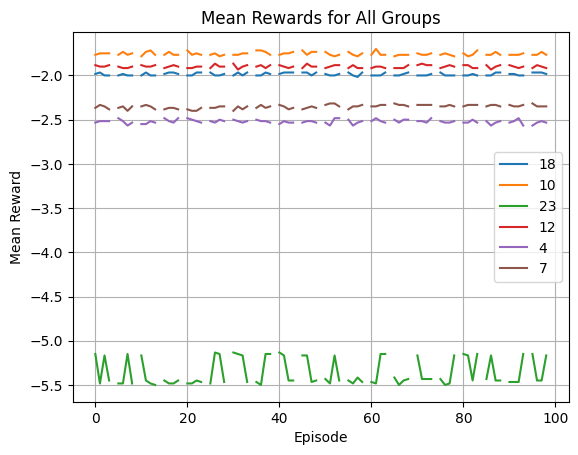

In [ ]:
plt.figure()
for group in env.group_map.keys():
    rewards = episode_reward_mean_map[group]
    plt.plot(rewards, label=group)

plt.title('Mean Rewards for All Groups')
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.legend()
plt.grid(True)
plt.show()

## Losses

### Total loss

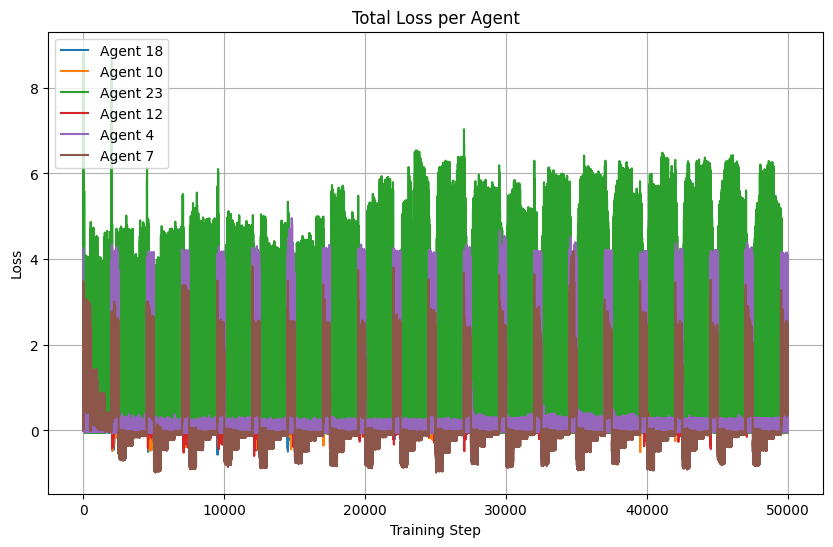

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

for agent_id, losses in loss.items():
    losses_np = [loss.detach().numpy() for loss in losses]
    plt.plot(losses_np, label=f'Agent {agent_id}')

plt.title('Total Loss per Agent')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Objective loss

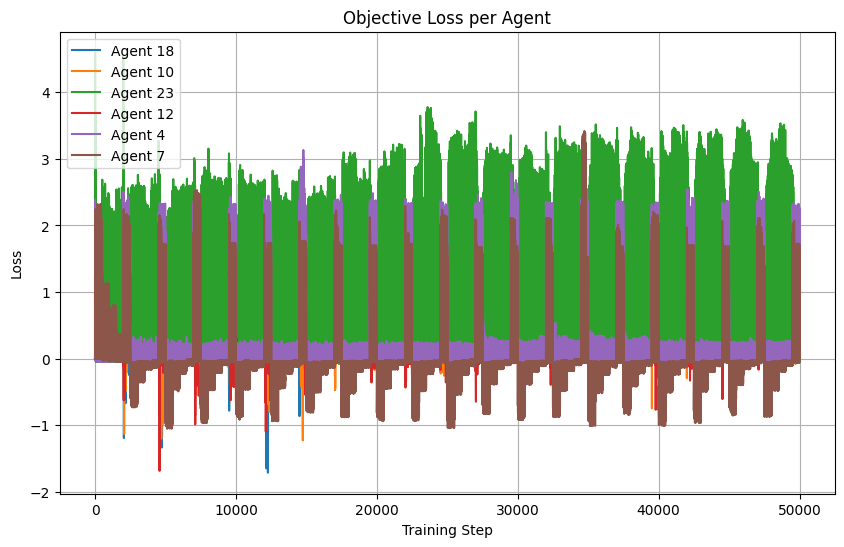

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

for agent_id, losses in loss_objective.items():
    losses_np = [loss.detach().numpy() for loss in losses]
    plt.plot(losses_np, label=f'Agent {agent_id}')

plt.title('Objective Loss per Agent')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Entropy loss

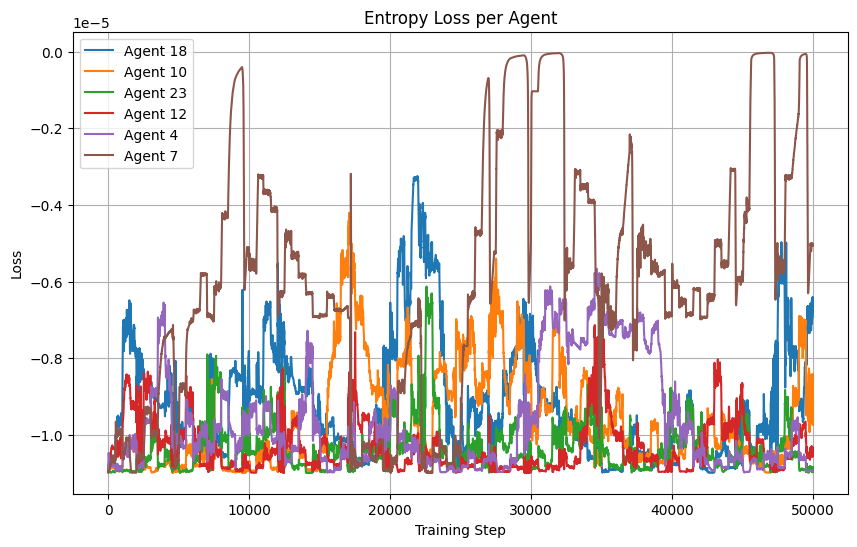

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

for agent_id, losses in loss_entropy.items():
    losses_np = [loss.detach().numpy() for loss in losses]
    plt.plot(losses_np, label=f'Agent {agent_id}')

plt.title('Entropy Loss per Agent')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Critic loss

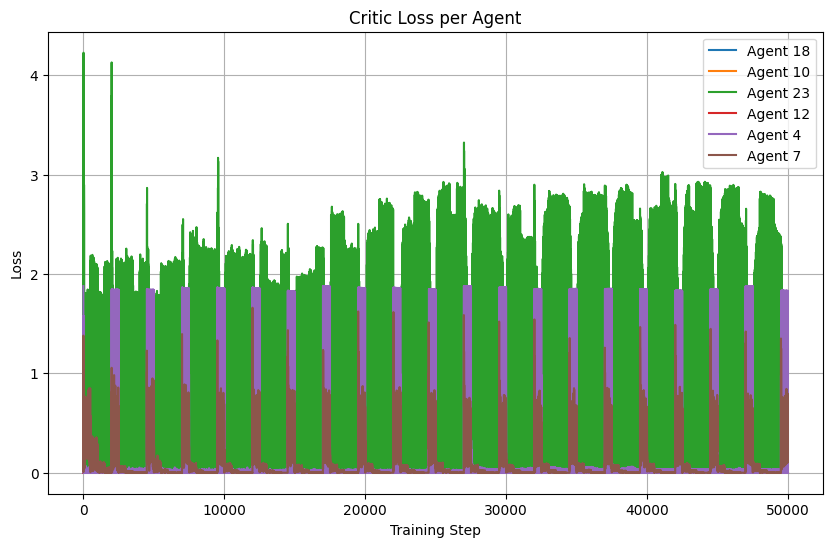

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

for agent_id, losses in loss_critic.items():
    losses_np = [loss.detach().numpy() for loss in losses]
    plt.plot(losses_np, label=f'Agent {agent_id}')

plt.title('Critic Loss per Agent')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

KeyError: 14

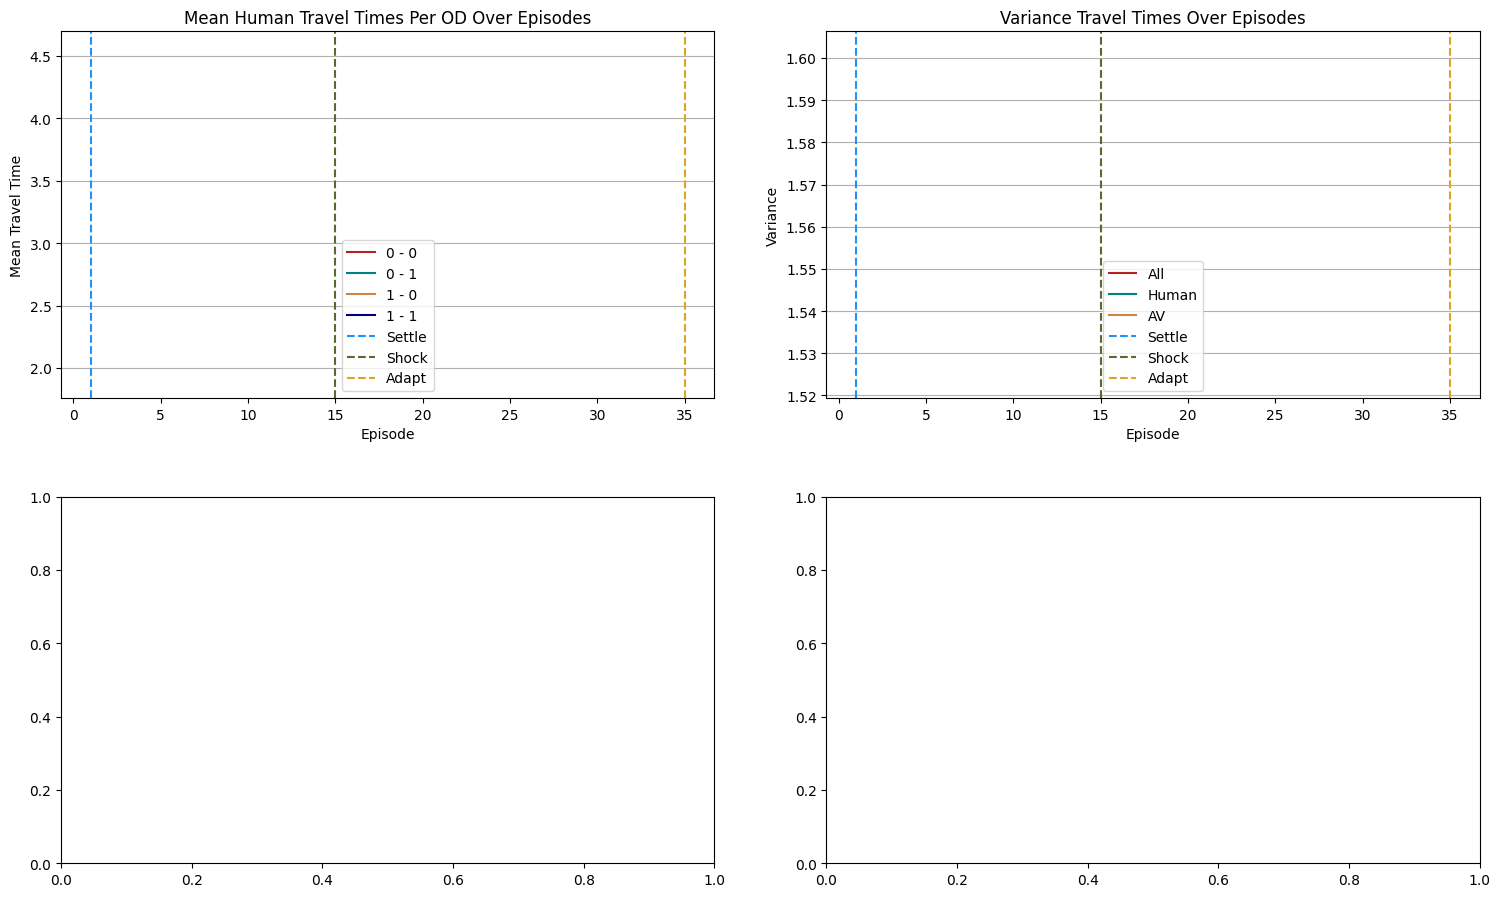

In [ ]:
from services import plotter

plotter(params[kc.PLOTTER])